In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.datasets import make_classification

import os
import re

import matplotlib.pyplot as plt
import seaborn as sns

import shap
from shap import TreeExplainer, summary_plot, dependence_plot

import imblearn 
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_validate

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgb


In [2]:
os.listdir()

['test.csv',
 'train.csv',
 '.ipynb_checkpoints',
 'gender_submission.csv',
 'Titanic.ipynb']

In [8]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
def clean(df):
    deck = [re.sub('[0-9]*','',str(i)) for i in df['Cabin']]
    deck = [None if i=='nan' else i for i in deck]
    room = [re.sub('[a-zA-Z]*','',str(i)) for i in df['Cabin']]
    room = [int(i.split()[0]) if i!='' else None for i in room]

    df['deck'] = deck
    df['room'] = room

    df['female'] = [1 if i=='female' else 0 for i in df['Sex']]
    df = df.drop('Sex', axis=1)

    df = df.join(pd.get_dummies(df['Embarked']))
    df.drop('Embarked', axis=1)

    floors = {'A': 1,
     'B': 2,
     'C': 3,
     'D': 4,
     'E': 5,
     'F': 6,
     'G': 7,
     None: None,
     'T': None
    }

    df['deck'] = [i.split()[0] if i!=None else None for i in df.deck]
    df['deck'] = [floors[i] for i in df['deck']]
    
    return(df)

In [9]:
train = clean(train)
test = clean(test)


In [10]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'deck', 'room', 'female', 'C',
       'Q', 'S'],
      dtype='object')

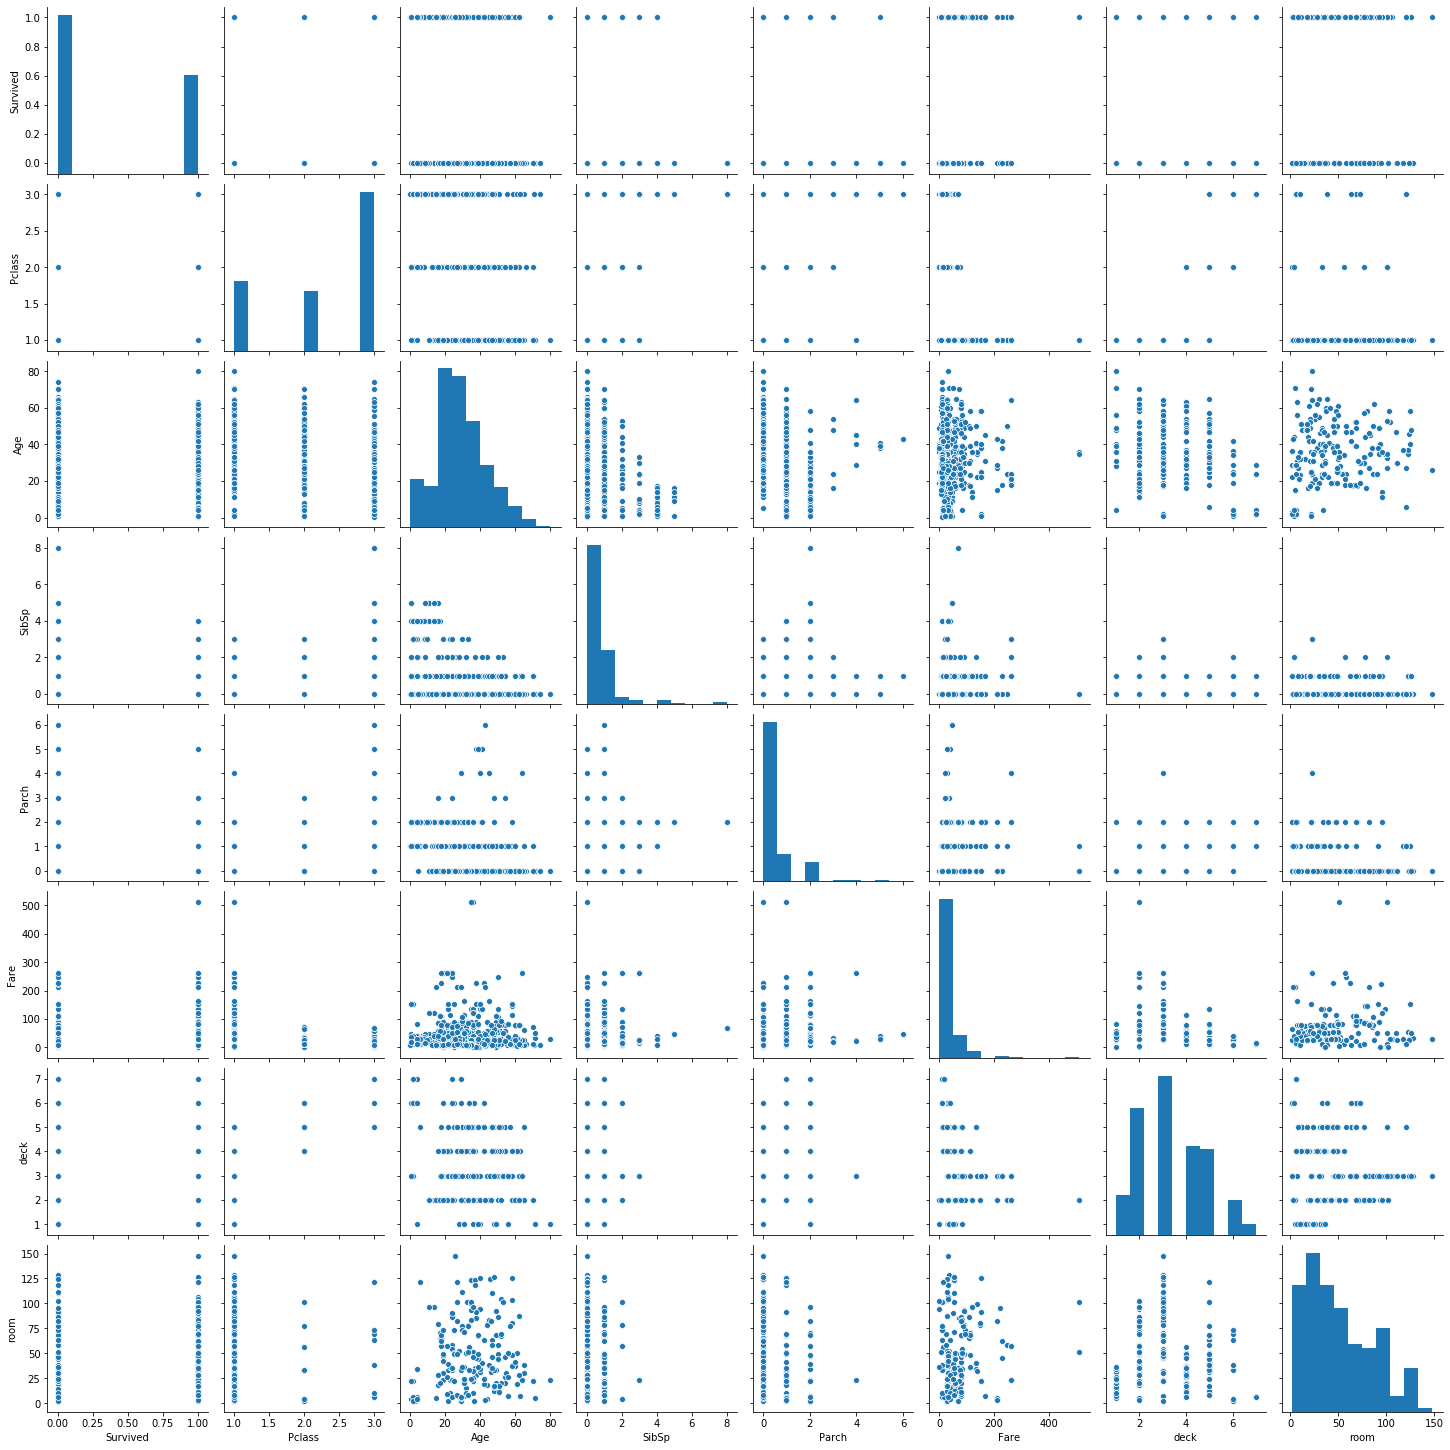

In [12]:
import seaborn as sns
sns.pairplot(train[['Survived', 'Pclass', 'Age', 'SibSp',
                    'Parch', 'Fare', 'deck', 'room']])

In [21]:
import statistics as stat
print(stat.mean(train[train.C==1]['Survived']))
print(stat.mean(train[train.Q==1]['Survived']))
print(stat.mean(train[train.S==1]['Survived']))

0.5535714285714286
0.38961038961038963
0.33695652173913043
